In [95]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import numpy as np
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN, Dense, Concatenate, Lambda

In [96]:
dataset = pd.read_csv("dataset/dataset.csv")
dataset = dataset.drop(columns=['date'])

In [101]:
dataset

,jdate,high,low,open,close,volume
0,1399-02-01,709012,691277,691277,708995,22.636634
1,1399-02-02,726964,716060,716060,726137,22.635195
2,1399-02-03,741952,729307,729307,741902,22.486639
3,1399-02-06,770549,750464,750464,769373,21.907705
4,1399-02-07,798105,780468,780468,797813,22.889805
...,...,...,...,...,...,...
961,1403-02-01,2285850,2235520,2235520,2285844,22.936868
962,1403-02-02,2316130,2302420,2302420,2312818,22.765422
963,1403-02-03,2318550,2310720,2312280,2316803,22.577616
964,1403-02-04,2316750,2303370,2316750,2303378,22.706838


In [97]:
dataset['volume'] = np.log1p(dataset['volume'])
scaler = StandardScaler()
scaled_columns = scaler.fit_transform(dataset[['high', 'low', 'open', 'close', 'volume']])
scaled_df = pd.DataFrame(scaled_columns, columns=['high', 'low', 'open', 'close', 'volume'])
min_max_scaler = MinMaxScaler()
scaled_columns_min_max = min_max_scaler.fit_transform(scaled_df[['high', 'low', 'open', 'close', 'volume']])
df = pd.DataFrame(scaled_columns_min_max, columns=['high', 'low', 'open', 'close', 'volume'])

In [98]:
import numpy as np

def create_sequences(values, window_size):
    X, y = [], []
    for i in range(len(values) - window_size):
        X.append(values[i:(i + window_size)])
        y.append(values[i + window_size][-2]) # close is last before last col
    return np.array(X), np.array(y)

window_size = 6 
X, y = create_sequences(df.values, window_size)


In [99]:
train_X, test_X = X[:-150], X[-150:]
train_y, test_y = y[:-150], y[-150:]

In [100]:
train_data = tf.data.Dataset.from_tensor_slices((train_X, train_y))
train_data = train_data.batch(32).shuffle(buffer_size=1000)
test_data = tf.data.Dataset.from_tensor_slices((test_X, test_y))
test_data = test_data.batch(32)

# Elman

In [62]:
model = Sequential([
    Input(shape=(window_size, train_X.shape[2])),
    SimpleRNN(20, activation='relu'),
    Dense(1)
])

In [63]:
model.compile(optimizer='adam', loss='mse')
history = model.fit(train_data, epochs=20, validation_data=test_data)

Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1248 - val_loss: 0.0307
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0205 - val_loss: 0.0406
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0111 - val_loss: 0.0367
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0143 - val_loss: 0.0247
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069 - val_loss: 0.0086
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019 - val_loss: 1.4581e-04
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0831e-04 - val_loss: 1.8310e-04
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7835e-04 - val_loss: 1.1980e-04
Epoch 9/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7361e-04 - val_loss: 2.2881e-04
Epoch 10/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6365e-04 - val_loss: 2.3247e-04
Epoch 11/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8642e-04 - val_loss: 1.5292e-04
Epoch 12/20
26/26 ━━━━━━━━━━━━

In [64]:
loss = model.evaluate(test_data)
print(f'Test Loss: {loss}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 1.0053e-04  
Test Loss: 0.00012596497253980488


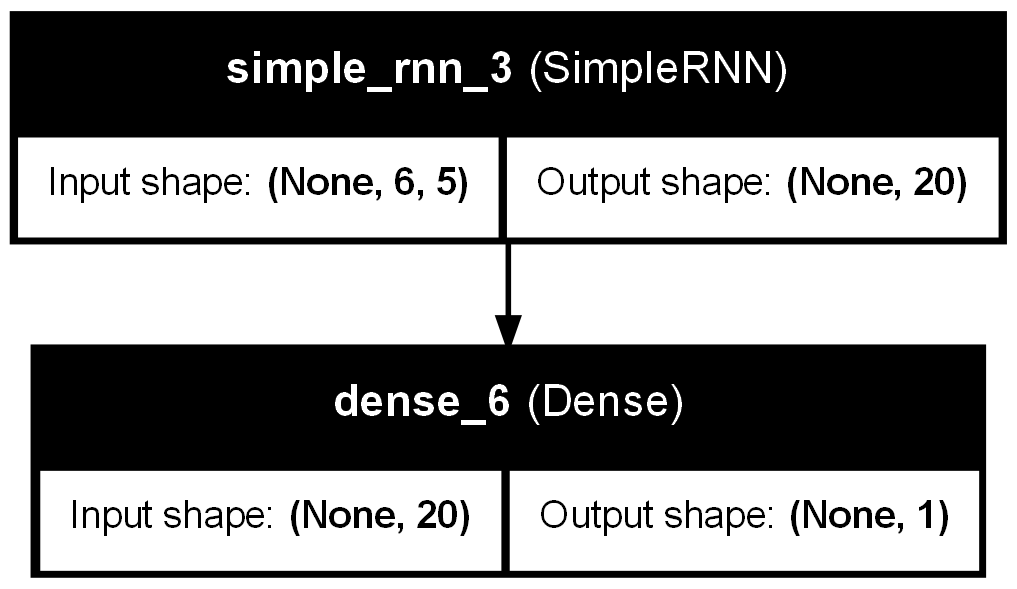

In [65]:
plot_model(model, to_file='elman_model.png', show_shapes=True, show_layer_names=True)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  


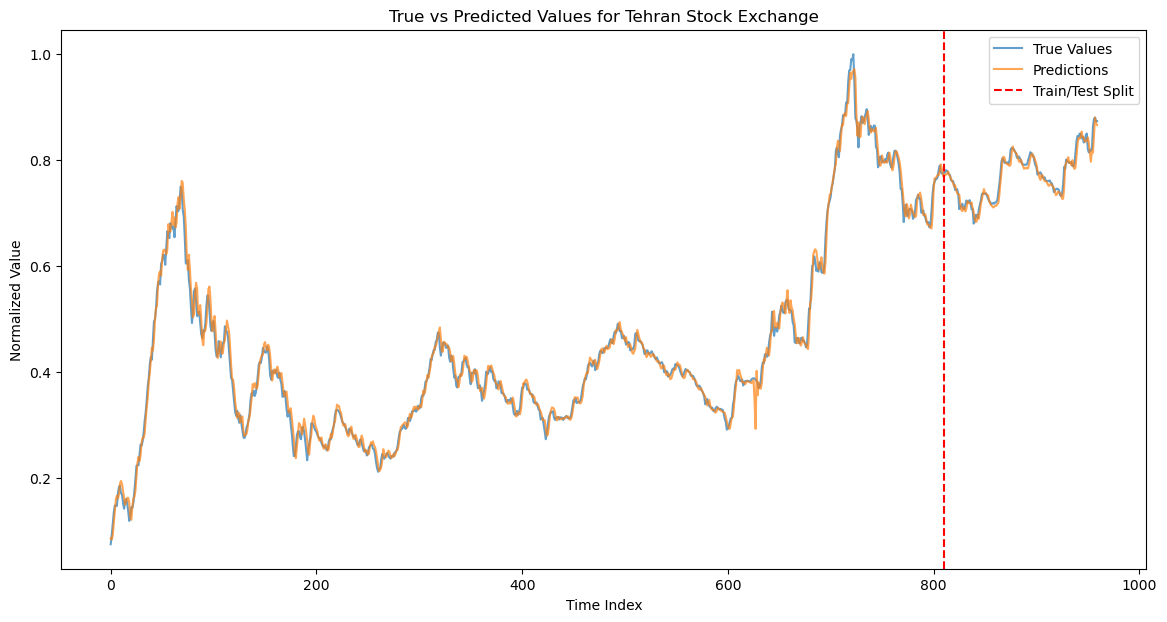

In [67]:
train_predictions = model.predict(train_X)
test_predictions = model.predict(test_X)
true_values = np.concatenate((train_y, test_y), axis=0)
predictions = np.concatenate((train_predictions, test_predictions), axis=0)
plt.figure(figsize=(14, 7))
plt.plot(true_values, label='True Values', alpha=0.7)
plt.plot(predictions, label='Predictions', alpha=0.7)
plt.axvline(x=len(train_y), color='red', linestyle='--', label='Train/Test Split')
plt.title('True vs Predicted Values for Tehran Stock Exchange')
plt.xlabel('Time Index')
plt.ylabel('Normalized Value')
plt.legend()
plt.show()

# Jordan

In [93]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Input, RNN
from tensorflow.keras.models import Model

class JordanRNNCell(Layer):
    def __init__(self, h_dim, out_dim):
        super(JordanRNNCell, self).__init__()
        self.h_dim = h_dim
        self.out_dim = out_dim
        self.in_to_h = None
        self.h_to_out = None
        self.out_to_h = None

    def build(self, input_shape):
        self.in_to_h = Dense(self.h_dim, activation='relu')
        self.h_to_out = Dense(self.out_dim)
        self.out_to_h = Dense(self.h_dim, activation='relu')
        super().build(input_shape)

    @property
    def state_size(self):
        return self.out_dim

    def call(self, inputs, states):
        prev_output = states[0]
        h_t = self.in_to_h(inputs) + self.out_to_h(prev_output)
        y_t = self.h_to_out(h_t)
        return y_t, [y_t]

def build_jordan_rnn(input_shape, h_dim, out_dim):
    inputs = Input(shape=input_shape)
    rnn_layer = RNN(JordanRNNCell(h_dim, out_dim), return_sequences=False)(inputs)
    model = Model(inputs=inputs, outputs=rnn_layer)
    return model

window_size = 6
input_shape = (window_size, train_X.shape[2]) 
h_dim =  30
out_dim = 1

jordan_rnn_model = build_jordan_rnn(input_shape, h_dim, out_dim)
jordan_rnn_model.compile(optimizer='adam', loss='mse')

In [94]:
history = jordan_rnn_model.fit(train_X, train_y, epochs=20, validation_data=(test_X, test_y))

Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.5066 - val_loss: 0.2258
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0470 - val_loss: 0.0012
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0059 - val_loss: 0.0107
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0026 - val_loss: 0.0047
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.0933e-04 - val_loss: 6.8874e-04
Epoch 9/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.8927e-04 - val_loss: 4.2292e-04
Epoch 10/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5692e-04 - val_loss: 2.9111e-04
Epoch 11/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4278e-04 - val_loss: 2.0921e-04
Epoch 12/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s

In [91]:
test_loss = jordan_rnn_model.evaluate(test_X, test_y)
print(f'Test loss: {test_loss}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4871e-04 
Test loss: 0.00018720817752182484


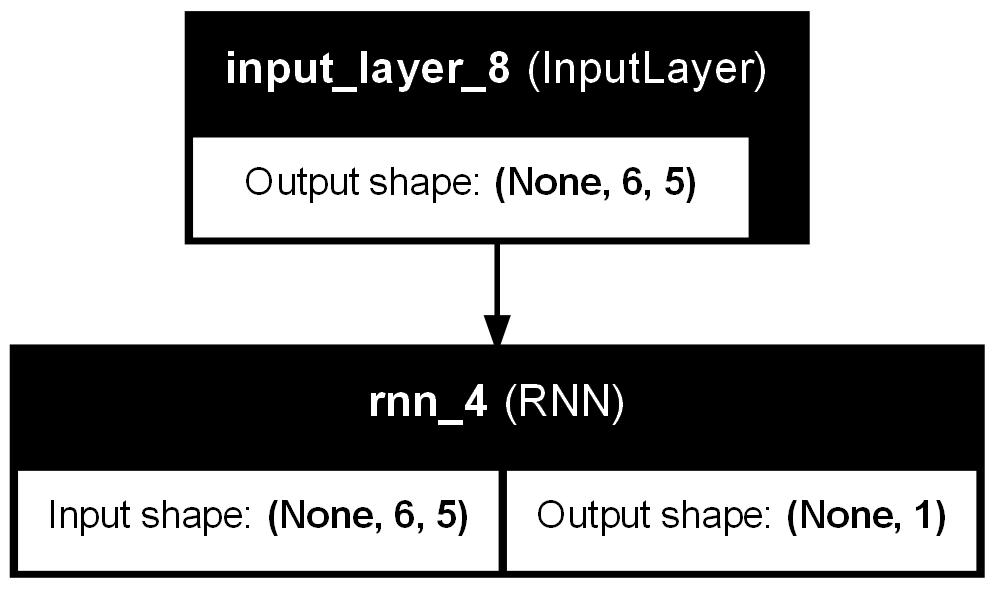

In [92]:
from tensorflow.keras.utils import plot_model
plot_model(jordan_rnn_model, to_file='jordan_model.png', show_shapes=True, show_layer_names=True)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  


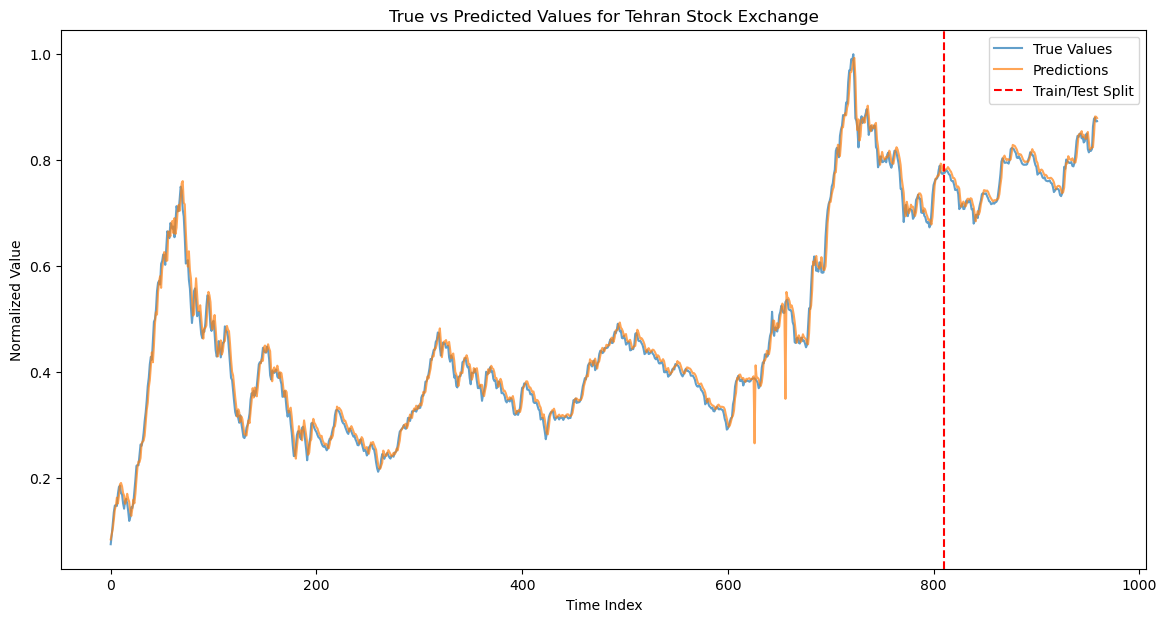

In [88]:
train_predictions = jordan_rnn_model.predict(train_X)
test_predictions = jordan_rnn_model.predict(test_X)
true_values = np.concatenate((train_y, test_y), axis=0)
predictions = np.concatenate((train_predictions, test_predictions), axis=0)
plt.figure(figsize=(14, 7))
plt.plot(true_values, label='True Values', alpha=0.7)
plt.plot(predictions, label='Predictions', alpha=0.7)
plt.axvline(x=len(train_y), color='red', linestyle='--', label='Train/Test Split')
plt.title('True vs Predicted Values for Tehran Stock Exchange')
plt.xlabel('Time Index')
plt.ylabel('Normalized Value')
plt.legend()
plt.show()